# 01. Data Exploration and Visualization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import sys
from collections import defaultdict

#### Setup Project Root Path
This allows the notebook to import modules from the 'src' directory. <br />
(*Adjust the number of '..' if your notebook is in a different subdirectory depth.*)

In [2]:
try:
    project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    if project_root not in sys.path:
        sys.path.insert(0, project_root)
    from src.utils import load_config, setup_logging
    from src.data_loader import get_data_loaders, ColoredMNISTDataset
except ImportError:
    print("Make sure your notebook is in the 'notebooks' directory of the project,")
    print("or adjust the path to include the 'src' directory.")
    raise

#### Configuration
Ensure this config file points to the downloaded Colored MNIST dataset, and has the proper parameters set.

In [4]:
CONFIG_FILE_PATH = os.path.join(project_root, "configs", "colored_mnist_default.yaml")

if not os.path.exists(CONFIG_FILE_PATH):
    print(f"ERROR: Configuration file not found at {CONFIG_FILE_PATH}")
    print("Please ensure you have a configuration file (e.g., 'colored_mnist_default.yaml') in the 'configs' directory.")
    print("This notebook requires a valid config to load dataset parameters.")
    
config = load_config(CONFIG_FILE_PATH)

#### Dataset Loading
We'll load the training dataset for exploration.
The get_data_loaders function can also create a validation split, but we'll use the full train set here.

In [7]:
if 'data' in config and 'path' in config['data']:
    if not os.path.isabs(config['data']['path']):
        # Resolve the relative path from the project root
        absolute_data_path = os.path.join(project_root, config['data']['path'])
        config['data']['path'] = os.path.abspath(absolute_data_path) # Normalize (e.g. remove ../)
        print(f"NOTEBOOK: Updated config['data']['path'] to absolute: {config['data']['path']}")
else:
    print("WARNING: 'data' or 'data.path' not found in config. Data loading might fail.")

try:
    train_loader, _, _ = get_data_loaders(config, create_val_loader=False)
    dataset = train_loader.dataset # Access the underlying Dataset object
    print(f"Dataset loaded: {config['data']['name']}")
    print(f"Number of training samples: {len(dataset)}")
except FileNotFoundError as e:
    print(f"ERROR: Dataset .npy file not found. {e}")
    print(f"Please ensure you have run 'scripts/download_dataset.sh' and that the 'data.path' ({config['data']['path']}) and 'data.color_var' ({config['data']['color_var']}) in your config are correct.")
    raise
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    raise

NOTEBOOK: Updated config['data']['path'] to absolute: /home/studio-lab-user/learning-not-to-learn/data/colored_mnist
Dataset loaded: ColoredMNIST
Number of training samples: 60000


#### Visualization Utilities

In [8]:
# De-normalization function
MEAN = torch.tensor([0.4914, 0.4822, 0.4465])
STD = torch.tensor([0.2023, 0.1994, 0.2010])

def denormalize_image(tensor_image):
    img = tensor_image.clone()
    for t, m, s in zip(img, MEAN, STD):
        t.mul_(s).add_(m)
    img = img.clamp(0, 1)
    return img

def imshow(tensor_img, title=None, ax=None):
    denorm_img = denormalize_image(tensor_img)
    npimg = denorm_img.numpy()
    if ax is None:
        plt.figure(figsize=(3,3))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        if title:
            plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        if title:
            ax.set_title(title)
        ax.axis('off')

#### 1. Display Sample Images


--- Displaying Sample Images ---


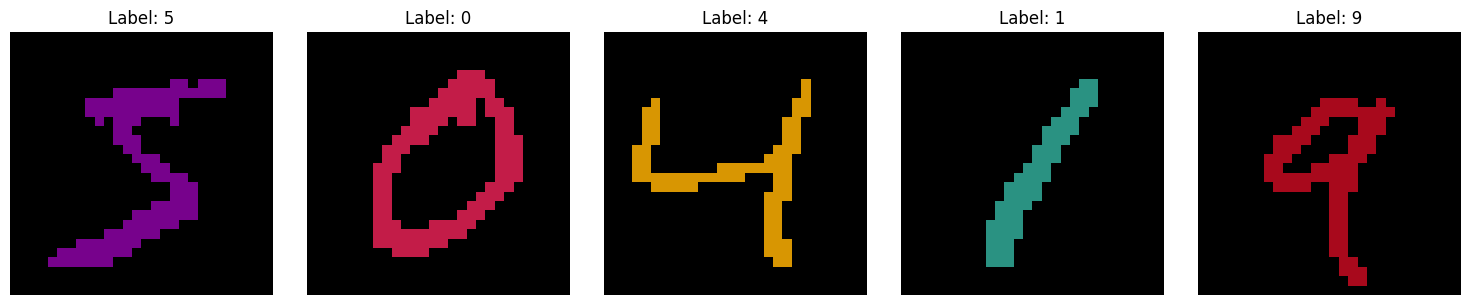

In [9]:
print("\n--- Displaying Sample Images ---")
num_samples_to_show = 5
fig, axes = plt.subplots(1, num_samples_to_show, figsize=(15, 3))
if num_samples_to_show == 1:
    axes = [axes] 

for i in range(num_samples_to_show):
    if i < len(dataset):
        img_tensor, _, main_label = dataset[i] 
        title = f"Label: {main_label.item()}"
        imshow(img_tensor, title=title, ax=axes[i])
    else:
        axes[i].axis('off')
plt.tight_layout()
plt.show()

#### 2. Analyze Color Bias per Digit Class


--- Analyzing Color Bias per Digit Class ---

Digit Class: 0


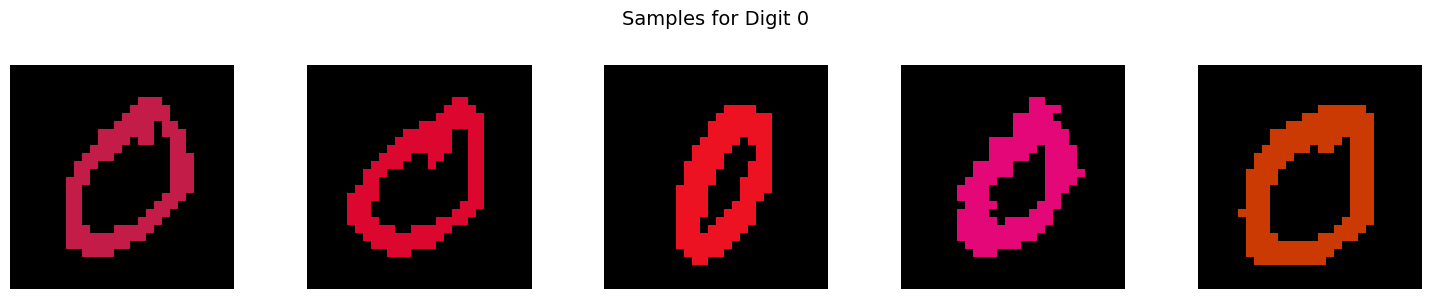


Digit Class: 1


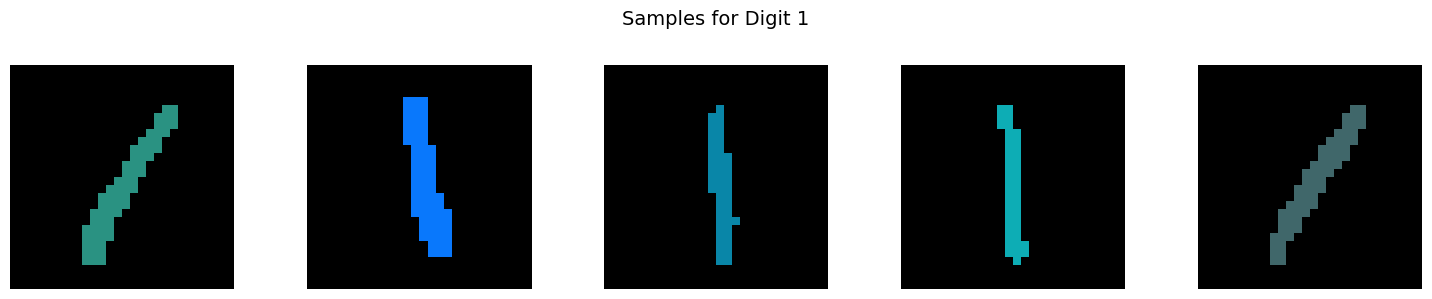


Digit Class: 2


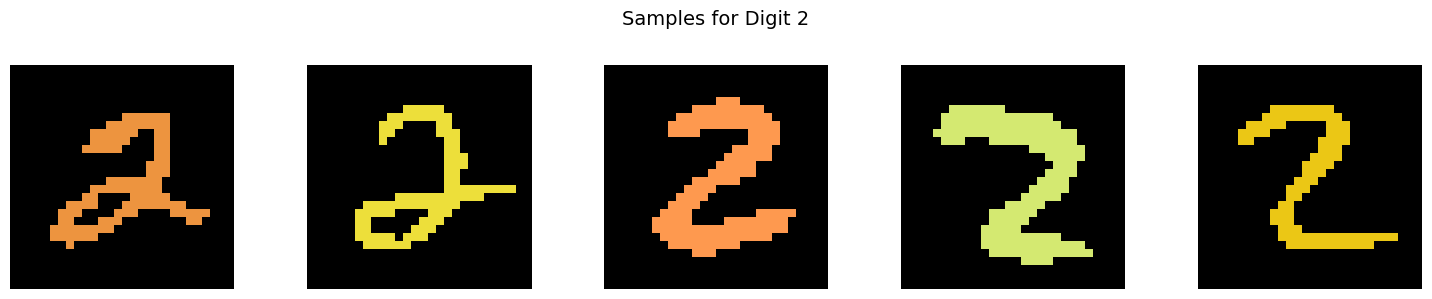


Digit Class: 3


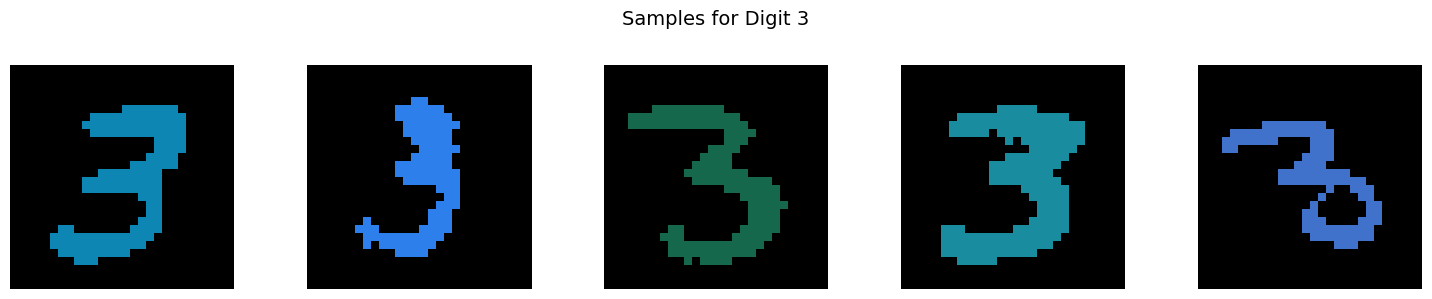


Digit Class: 4


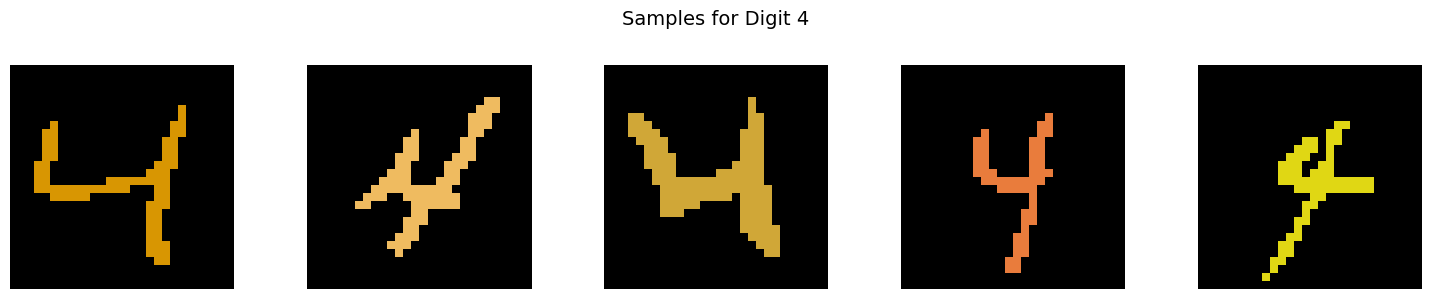


Digit Class: 5


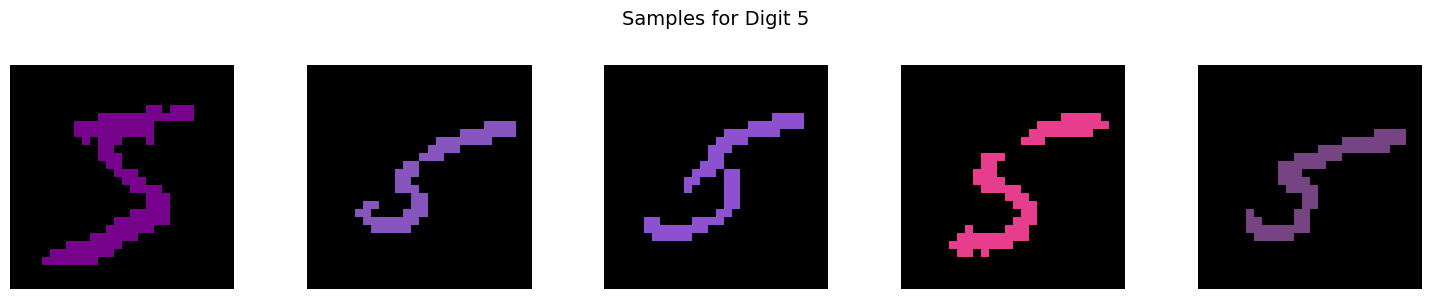


Digit Class: 6


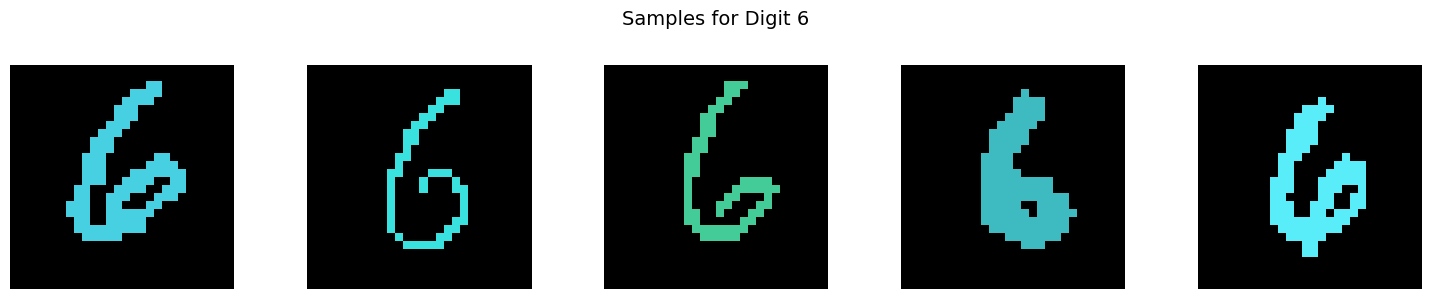


Digit Class: 7


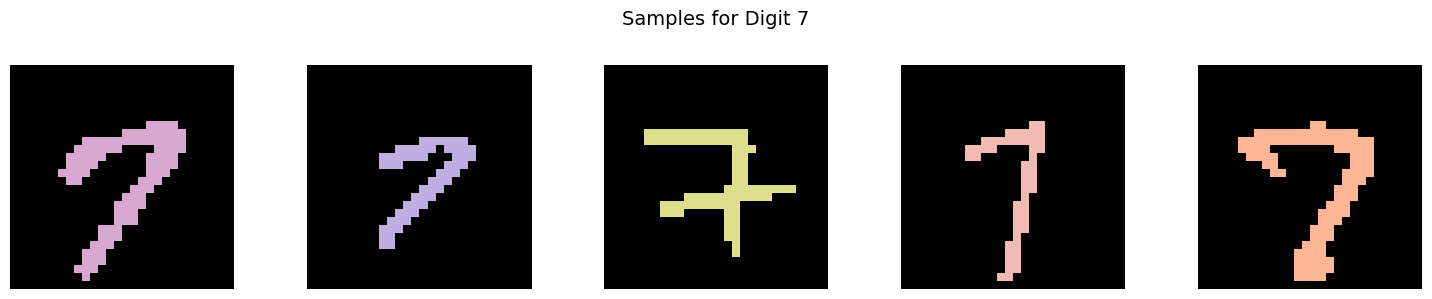


Digit Class: 8


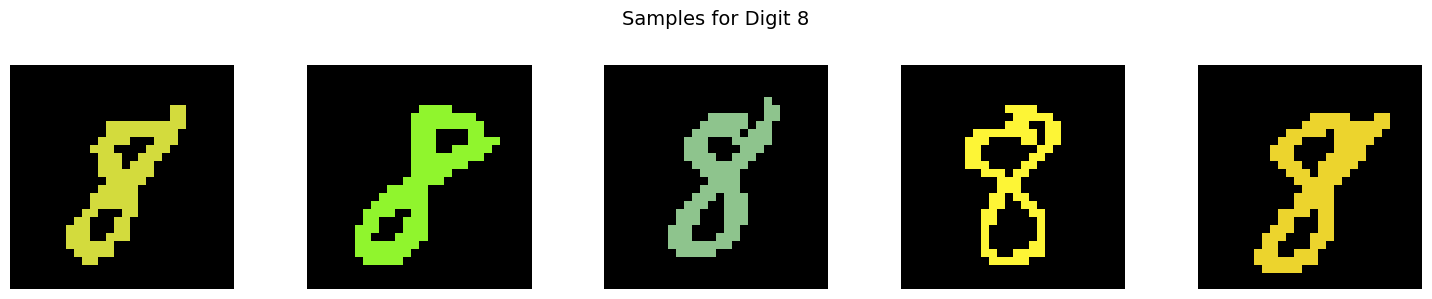


Digit Class: 9


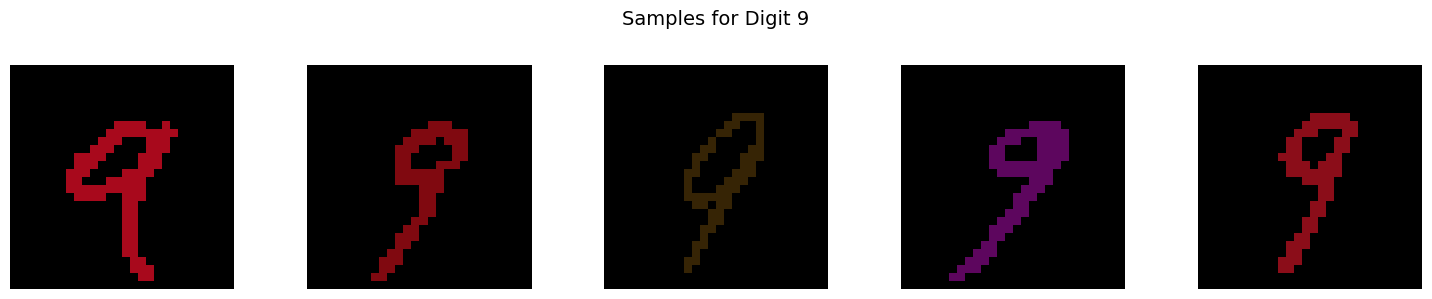

In [10]:
print("\n--- Analyzing Color Bias per Digit Class ---")
images_by_class = defaultdict(list)
avg_colors_by_class = defaultdict(list)
max_samples_per_class_for_grid = 5 
max_samples_for_color_avg = 50

for i in range(len(dataset)):
    img_tensor, _, main_label_tensor = dataset[i]
    label = main_label_tensor.item()

    if len(images_by_class[label]) < max_samples_per_class_for_grid:
        images_by_class[label].append(img_tensor)
    
    if len(avg_colors_by_class[label]) < max_samples_for_color_avg:
        denorm_img = denormalize_image(img_tensor)
        avg_color = denorm_img.mean(dim=[1,2]).numpy()
        avg_colors_by_class[label].append(avg_color)

num_classes = config['data']['num_main_classes']
for class_idx in range(num_classes):
    if images_by_class[class_idx]:
        print(f"\nDigit Class: {class_idx}")
        samples_for_class = images_by_class[class_idx]
        num_to_show = min(len(samples_for_class), max_samples_per_class_for_grid)
        fig_class, axes_class = plt.subplots(1, num_to_show, figsize=(num_to_show * 3, 3))
        if num_to_show == 1: axes_class = [axes_class]
        for i in range(num_to_show):
            imshow(samples_for_class[i], ax=axes_class[i])
        plt.suptitle(f"Samples for Digit {class_idx}", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    else:
        print(f"\nNo samples collected for Digit Class: {class_idx} within the iterated portion.")

#### 3. Display Average Colors per Digit Class


--- Average Colors per Digit Class ---


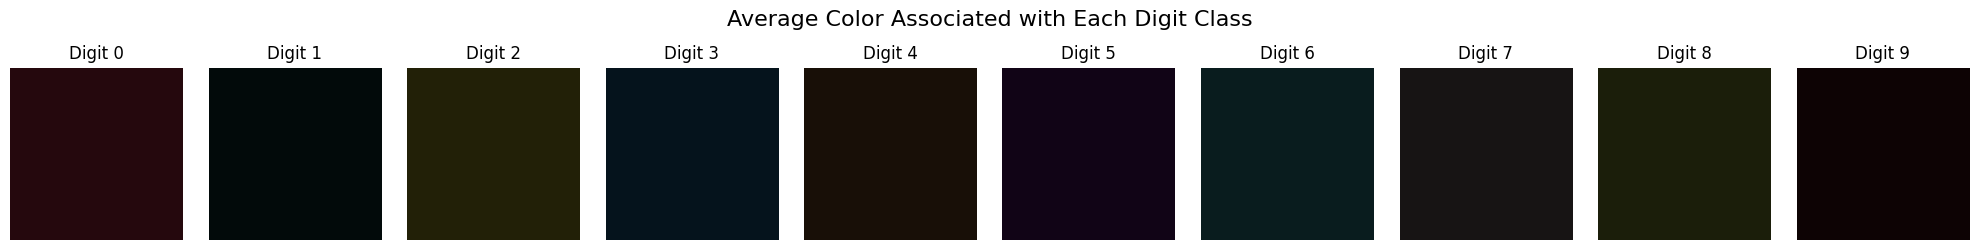

In [11]:
print("\n--- Average Colors per Digit Class ---")
fig_colors, ax_colors = plt.subplots(1, num_classes, figsize=(num_classes * 2, 2.5))
if num_classes == 1: ax_colors = [ax_colors]

for class_idx in range(num_classes):
    if avg_colors_by_class[class_idx]:
        class_avg_color = np.mean(avg_colors_by_class[class_idx], axis=0)
        class_avg_color_clipped = np.clip(class_avg_color, 0, 1)
        swatch = np.full((50, 50, 3), class_avg_color_clipped)
        ax_colors[class_idx].imshow(swatch)
        ax_colors[class_idx].set_title(f"Digit {class_idx}")
        ax_colors[class_idx].axis('off')
    else:
        ax_colors[class_idx].set_title(f"Digit {class_idx}\n(No data)")
        ax_colors[class_idx].axis('off')

plt.suptitle("Average Color Associated with Each Digit Class", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()